In [1]:
import sys
sys.path.append('../../coco-helper/src')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

from cocohelper import COCOHelper
from cocohelper.validator import COCOValidator
from cocohelper.stats import COCOStats
from cocohelper.visualizer import COCOVisualizer, convert_to_mode

## Data Loaders with COCO Helper
In this tutorial, we will see how it is possible to integrate COCO Helper in your data loaders when training a deep learning model using [TensorFlow](https://www.tensorflow.org) (or Keras) or [PyTorch](https://pytorch.org). Be aware that to run the code below you will need TensorFlow or PyTorch to be installed on your machine.

For our examples, we'll be using data and annotations obtained from the [COCO Dataset](http://www.cocodataset.org). However, to make dataset download and the snippets run faster, we created a smaller version of the dataset, named `microCOCO`, that only contains a small subset of images and annotations from the entire COCO dataset. We left image names and ids unchanged so that you can easily find these images in the originary dataset.


In [3]:
# download the dataset
!wget https://github.com/AILAB-bh/coco-helper/tree/master/data/tutorial_material/micro_coco.zip -O ./data/micro_coco.zip
!unzip -o ./data/micro_coco.zip

## Writing a Python Data Loader
First, let's write a data loader using COCO Helper in Python.\
 --> *We will show how to integrate this loader into standard TensorFlow or PyTorch data pipelines below.*

Lets define a few helpers...

In [4]:
# dataset path:
root = "./micro_coco"
annotations_file = f"{root}/annotations/annotations.json"
image_dir = "images"  # this is the image dir relative path, expected to be under the same root when using COCOHelper.load_json()

# now the helpers:

print(f"Loading dataset: {annotations_file}")
ch = COCOHelper.load_json(annotations_file, img_dir=image_dir)

print(f"Verify if this dataset is in valid COCO format... ", end="")
is_valid = COCOValidator(ch).validate_dataset()
print(f"Done, validation results to: {is_valid}")

print("Create COCOStats object to extract statistics on the dataset items")
cs = COCOStats(ch)

print("Create a COCOVisualizer to help creating segmentation masks as numpy arrays")
cv = COCOVisualizer(ch)

# -----
# compute optimal image size for resizing images to a common size:
optimal_image_size = cs.get_optimal_image_size(mode="mean", n_pixels=4)

Loading dataset: ./micro_coco/annotations/annotations.json
Verify if this dataset is in valid COCO format... Done, validation results to: True
Create COCOStats object to extract statistics on the dataset items
Create a COCOVisualizer to help creating segmentation masks as numpy arrays


...and the loader function:

In [5]:
# Loader function:

def py_loader(img_id, coco_helper: COCOHelper = ch, visualizer=cv, output_shape=optimal_image_size):
    """ Returns an image and its segmentation mask given a COCOHelper and the image id"""

    # load the image array having the given image id:
    image = coco_helper.get_img(img_id=int(img_id))

    # load the annotations for the given image id:
    annotations = coco_helper.filtered_anns(img_ids=int(img_id)).to_dict("records")

    # load the segmentation mask:
    h, w = image.shape[0], image.shape[1]
    mask = np.zeros((h, w))
    if len(annotations) > 0:
        segmentations, bboxes, label = \
                        zip(*[(convert_to_mode(a["segmentation"], mode='polygon',
                                               height=h, width=w), a["bbox"], a["category_id"]) for a in annotations])
        colors = visualizer.pick_color_palette(number=len(bboxes))
        for segm, bbox, lab, col in zip(segmentations, bboxes, label, colors):
            col = tuple((int(col[0]), int(col[1]), int(col[2])))
            mask = visualizer.draw_segmentation_mask(image=mask, segmentation=segm, color=col)
    mask = mask.astype(np.float32)
    
    # for aliasing, see: https://github.com/beresandras/buggy-resizing-critique/blob/master/buggy_resizing_critique.ipynb
    image = cv2.resize(image, output_shape, interpolation=cv2.INTER_AREA)
    mask = cv2.resize(mask, output_shape, interpolation=cv2.INTER_AREA)
    
    return image, mask


## Tensorflow (or Keras)
Below, we show how you can easily integrate the python data loader in a `tf.data.Dataset` for your training pipeline.\
To run this example, you need to have [TensorFlow](https://www.tensorflow.org) (or Keras) installed.

Batch #00 -- shapes: images=(4, 648, 485, 3), masks=(4, 648, 485)
Batch #01 -- shapes: images=(4, 648, 485, 3), masks=(4, 648, 485)
Batch #02 -- shapes: images=(4, 648, 485, 3), masks=(4, 648, 485)
Batch #03 -- shapes: images=(4, 648, 485, 3), masks=(4, 648, 485)
Batch #04 -- shapes: images=(4, 648, 485, 3), masks=(4, 648, 485)
Batch #05 -- shapes: images=(4, 648, 485, 3), masks=(4, 648, 485)
Batch #06 -- shapes: images=(4, 648, 485, 3), masks=(4, 648, 485)
Batch #07 -- shapes: images=(4, 648, 485, 3), masks=(4, 648, 485)
Batch #08 -- shapes: images=(4, 648, 485, 3), masks=(4, 648, 485)
Batch #09 -- shapes: images=(4, 648, 485, 3), masks=(4, 648, 485)


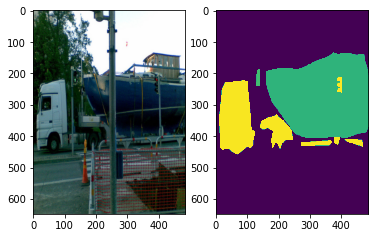

In [7]:
import tensorflow as tf

# obtain the list of image ids (index argument of the dataframe ch.imgs) and convert to tf.constant:
dataset_ids = list(ch.imgs.index)
ids = tf.constant(dataset_ids)

# create a dataset of ids:
dataset = tf.data.Dataset.from_tensor_slices(ids)

# map the python data loader to each image id of the tensorflow dataset:
tf_loader = lambda iid: tf.py_function(py_loader, [iid], [tf.float32, tf.float32])
dataset = dataset.map(lambda image_id: tf_loader(image_id), num_parallel_calls=tf.data.AUTOTUNE)

# batch the data:
b_size = 4
dataset = dataset.batch(b_size, drop_remainder=True)

# and you are ready to go with your standard training pipeline!
k = 0
for (images, masks) in dataset:
    print(f"Batch #{str(k).zfill(2)} -- shapes: images={images.shape}, masks={masks.shape}")
    # do your standard training here:
    # ...
    k += 1

# visualize the first image of the last batch:
fig, a = plt.subplots(1, 2)
a[0].imshow(images[0] / 255)  # rescale the image for better visibility
a[1].imshow(masks[0], interpolation="nearest")
plt.show()

## PyTorch
Below, we show how you can easily integrate the python data loader in PyTorch.\
To run this example, you need to have [PyTorch](https://pytorch.org) installed.

Batch #00 -- shapes: images=torch.Size([4, 648, 485, 3]), masks=torch.Size([4, 648, 485])
Batch #01 -- shapes: images=torch.Size([4, 648, 485, 3]), masks=torch.Size([4, 648, 485])
Batch #02 -- shapes: images=torch.Size([4, 648, 485, 3]), masks=torch.Size([4, 648, 485])
Batch #03 -- shapes: images=torch.Size([4, 648, 485, 3]), masks=torch.Size([4, 648, 485])
Batch #04 -- shapes: images=torch.Size([4, 648, 485, 3]), masks=torch.Size([4, 648, 485])
Batch #05 -- shapes: images=torch.Size([4, 648, 485, 3]), masks=torch.Size([4, 648, 485])
Batch #06 -- shapes: images=torch.Size([4, 648, 485, 3]), masks=torch.Size([4, 648, 485])
Batch #07 -- shapes: images=torch.Size([4, 648, 485, 3]), masks=torch.Size([4, 648, 485])
Batch #08 -- shapes: images=torch.Size([4, 648, 485, 3]), masks=torch.Size([4, 648, 485])
Batch #09 -- shapes: images=torch.Size([4, 648, 485, 3]), masks=torch.Size([4, 648, 485])
Batch #10 -- shapes: images=torch.Size([1, 648, 485, 3]), masks=torch.Size([1, 648, 485])


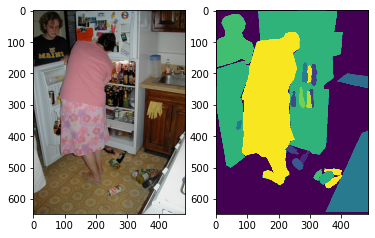

In [6]:
from torch.utils.data import Dataset, DataLoader


class COCODataset(Dataset):
    def __init__(self, coco_helper=ch, visualizer=cv, image_size=optimal_image_size, **kwargs):
        super().__init__()
        
        # store internal variables
        self.coco_helper = coco_helper
        self.visualizer = visualizer
        self.image_size = image_size
        
        # obtain the list of image ids and wrap it with a dictionary with sequential keys:
        image_ids = coco_helper.imgs.image_id
        self.dataset_ids = {k: el for k, el in enumerate(image_ids)}
        
    def __len__(self):
        """ Number of samples """
        return len(self.dataset_ids)

    def __getitem__(self, idx):
        """ Get one sample associated with the given index """
        # use the current index to get the image id from the ids dictionary:
        img_id = self.dataset_ids[idx]
        
        # call the python loader implemented before:
        image, mask = py_loader(img_id, self.coco_helper, self.visualizer, self.image_size)
        return image, mask


# instantiate a loader:
bsize = 4
loader = DataLoader(
    dataset=COCODataset(), 
    batch_size=bsize,
)

# and you are ready to go with your standard training pipeline!
k = 0
for (images, masks) in loader:    
    print(f"Batch #{str(k).zfill(2)} -- shapes: images={images.shape}, masks={masks.shape}")
    # do your standard training here:
    # ...
    k += 1

# visualize the first image of the last batch:
fig, a = plt.subplots(1, 2)
a[0].imshow(images[0] / 255)  # rescale the image for better visibility
a[1].imshow(masks[0], interpolation="nearest")
plt.show()